# 00_baseline_crab — Build CRAB baseline with sine basis


In [ ]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)



In [58]:
# --- Setup CRAB baseline ---
import numpy as np
from pathlib import Path
from src.qoc_common_crab import build_crab_bases

SEED = 42
rng = np.random.default_rng(SEED)

T = 0.1  # microseconds
Nt = 201
t = np.linspace(0.0, T, Nt)
dt = float(t[1] - t[0])

def rap_seed(t, T, area=4 * np.pi, delta_scale=0.55):
    s = 2 * (t / T) - 1.0
    shape = 1 - 3 * s**4 + 2 * s**6
    norm = area / (np.trapz(shape, t) + 1e-15)
    Omega = norm * shape
    Delta = norm * delta_scale * (1.25 * s - 0.25 * s**3)
    return Omega.astype(float), Delta.astype(float), float(norm)

Omega0, Delta0, NORM = rap_seed(t, T)

modes_omega = np.arange(1, 4, dtype=int)
modes_delta = np.arange(1, 4, dtype=int)
basis_omega, basis_delta = build_crab_bases(t, dt, T, modes_omega, modes_delta)

rho0 = np.array([[1, 0], [0, 0]], dtype=np.complex128)
target = np.array([[0, 0], [0, 1]], dtype=np.complex128)


Nt=201, dt=0.500 ns  |  T=0.100 us
Omega fluence = 1.975e+03 (rad/us)^2 us
Delta fluence = 4.112e+02 (rad/us)^2 us
CRAB modes: Omega=3, Delta=3
Omega range = (0.000, 183.260) rad/us
Delta range = (-100.793, 100.793) rad/us
FFT bins: f0=10.0 MHz, Nyquist=1000.0 MHz


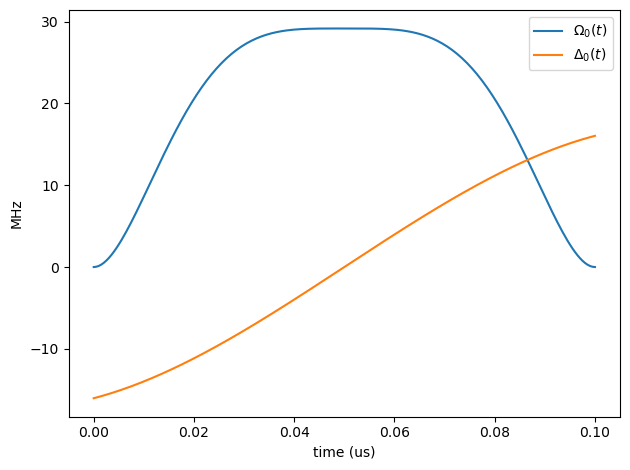

In [59]:
import matplotlib.pyplot as plt

fluence_Omega = np.trapz(Omega0**2, t)
fluence_Delta = np.trapz(Delta0**2, t)
f0 = 1.0 / (Nt * dt)
f_nyq = 0.5 / dt

print(
    f"Nt={Nt}, dt={dt * 1e3:.3f} ns  |  T={T:.3f} us\n"
    f"Omega fluence = {fluence_Omega:.3e} (rad/us)^2 us\n"
    f"Delta fluence = {fluence_Delta:.3e} (rad/us)^2 us\n"
    f"CRAB modes: Omega={len(modes_omega)}, Delta={len(modes_delta)}\n"
    f"Omega range = ({Omega0.min():.3f}, {Omega0.max():.3f}) rad/us\n"
    f"Delta range = ({Delta0.min():.3f}, {Delta0.max():.3f}) rad/us\n"
    f"FFT bins: f0={f0:.1f} MHz, Nyquist={f_nyq:.1f} MHz"
)

plt.figure()
plt.plot(t, Omega0 / (2 * np.pi), label=r"$\Omega_0(t)$")
plt.plot(t, Delta0 / (2 * np.pi), label=r"$\Delta_0(t)$")
plt.xlabel("time (us)")
plt.ylabel("MHz")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
import json, time

BASELINE_DIR = Path("outputs/_baseline_crab")
BASELINE_DIR.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
    BASELINE_DIR / "arrays.npz",
    t=t,
    dt=dt,
    T=T,
    Nt=Nt,
    Omega0=Omega0,
    Delta0=Delta0,
    CRAB_BASIS_OMEGA=basis_omega,
    CRAB_BASIS_DELTA=basis_delta,
    CRAB_MODES_OMEGA=modes_omega,
    CRAB_MODES_DELTA=modes_delta,
    rho0=rho0,
    target=target,
    NORM=NORM,
    SEED=SEED,
)

policy = {
    "saved_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "units_stored": {"time": "us", "amplitude": "rad/us"},
    "summary": {
        "Nt": int(Nt),
        "dt_ns": float(dt * 1e3),
        "T_us": float(T),
        "omega_fluence": float(fluence_Omega),
        "delta_fluence": float(fluence_Delta),
        "num_modes_omega": int(len(modes_omega)),
        "num_modes_delta": int(len(modes_delta)),
    },
    "penalties": {
        "power_weight": 0.00005,
        "neg_weight": 1.0,
        "neg_kappa": 1.0,
    },
    "seed": int(SEED),
    "note": "CRAB baseline with sine basis (zero endpoints); arrays saved in SI units.",
}

with open(BASELINE_DIR / "metadata.json", "w", encoding="utf-8") as f:
    json.dump(policy, f, indent=2)

print(f"[baseline saved] {BASELINE_DIR}/arrays.npz  and  metadata.json")


[baseline saved] outputs\_baseline_crab/arrays.npz  and  metadata.json
